In [1]:
!git clone https://github.com/TalwalkarLab/leaf.git
%cd leaf
# In leaf/data/shakespeare/preprocess/get_data.sh we should change the link
# to http://www.gutenberg.org/files/100/old/old/1994-01-100.zip and save that script

Cloning into 'leaf'...
remote: Enumerating objects: 782, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 782 (delta 1), reused 2 (delta 0), pack-reused 776 (from 1)
Receiving objects: 100% (782/782), 6.79 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (372/372), done.
/content/leaf


In [2]:
!pip install -r requirements.txt
%cd data/shakespeare
!./preprocess.sh --sf 0.2 -t sample -tf 0.8
%cd ../..

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==1.13.1
/content/leaf/data/shakespeare
--2025-01-18 09:34:31--  http://www.gutenberg.org/files/100/old/old/1994-01-100.zip
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 

In [3]:
ALL_LETTERS = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
NUM_LETTERS = len(ALL_LETTERS)
print(NUM_LETTERS)

def _one_hot(index, size): # this function returns one-hot vector with given size and value 1 at given index
    vec = [0 for _ in range(size)]
    vec[int(index)] = 1
    return vec

def letter_to_vec(letter): # this function returns one-hot representation of given letter
    index = ALL_LETTERS.find(letter)
    return _one_hot(index, NUM_LETTERS)

def word_to_indices(word): # this function returns indices of given word
    indices = []
    for c in word:
        indices.append(ALL_LETTERS.find(c))
    return indices

80


In [4]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import os

# Function to read and parse training and testing data
def read_data(train_data_path, test_data_path):
    def read_file(path):
        with open(path, 'r') as f:
            return json.load(f)

    train_data = read_file(train_data_path)
    test_data = read_file(test_data_path)

    # Extract users and their corresponding data from training and testing datasets
    train_clients = list(train_data['users'])  # List of training users
    train_groups = list(train_data['user_data'].keys())  # Groups for training data
    train_data_temp = train_data['user_data']  # Actual training data

    test_clients = list(test_data['users'])  # List of testing users
    test_groups = list(test_data['user_data'].keys())  # Groups for testing data
    test_data_temp = test_data['user_data']  # Actual testing data

    return train_clients, train_groups, train_data_temp, test_data_temp

# Custom Dataset class for the Shakespeare dataset
class Shakespeare(Dataset):
    def __init__(self, train=True, args=None):
        super(Shakespeare, self).__init__()

        # Read the training and testing data
        train_clients, train_groups, train_data_temp, test_data_temp = read_data(args.shakespeare_train_path, args.shakespeare_test_path)
        self.train = train

        if self.train:
            # For training, organize data into inputs and labels
            self.dic_users = {}
            train_data_x = []
            train_data_y = []
            for i, client in enumerate(train_clients):
                self.dic_users[i] = set()
                l = len(train_data_x)
                cur_x = train_data_temp[client]['x']
                cur_y = train_data_temp[client]['y']
                for j in range(len(cur_x)):
                    self.dic_users[i].add(j + l)
                    train_data_x.append(cur_x[j])
                    train_data_y.append(cur_y[j])
            self.data = train_data_x
            self.label = train_data_y
        else:
            # For testing, organize data without user mapping
            test_data_x = []
            test_data_y = []
            for i, client in enumerate(train_clients):
                cur_x = test_data_temp[client]['x']
                cur_y = test_data_temp[client]['y']
                for j in range(len(cur_x)):
                    test_data_x.append(cur_x[j])
                    test_data_y.append(cur_y[j])
            self.data = test_data_x
            self.label = test_data_y

    def __len__(self):
        return len(self.data)

    # Fetches a single sample from the dataset by index.
    def __getitem__(self, index):
        sentence, target = self.data[index], self.label[index]
        indices = word_to_indices(sentence)
        target = letter_to_vec(target)
        indices = torch.LongTensor(np.array(indices))
        target = torch.FloatTensor(np.array(target))
        return indices, target

    # Returns the mapping of user IDs to their data indices.
    def get_client_dic(self):
        if self.train:
            return self.dic_users
        else:
            raise ValueError("The test dataset does not have dic_users!")

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader

class CharLSTM(nn.Module):
    def __init__(self):
        super(CharLSTM, self).__init__()
        embedding_dim = 8
        hidden_size = 100
        num_LSTM = 2
        input_length = 80
        self.n_cls = 80
        self.embedding = nn.Embedding(input_length, embedding_dim)
        self.stacked_LSTM = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_LSTM)
        self.fc = nn.Linear(hidden_size, self.n_cls)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        output, (h_, c_) = self.stacked_LSTM(x)
        last_hidden = output[-1, :, :]
        x = self.fc(last_hidden)

        return x

# Define the model, loss function, number of epochs, and optimizer
model = CharLSTM()
criterion = nn.CrossEntropyLoss()
epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

class Args:
    shakespeare_train_path = '/content/leaf/data/shakespeare/data/train/all_data_train_9.json'
    shakespeare_test_path = '/content/leaf/data/shakespeare/data/test/all_data_test_9.json'

args = Args()
train_dataset = Shakespeare(train=True, args=args)
test_dataset = Shakespeare(train=False, args=args)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import json
import os
import matplotlib.pyplot as plt

# Paths for saving results on Google Drive
save_dir = '/content/drive/My Drive/hyperparameter_tuning_results'
os.makedirs(save_dir, exist_ok=True)

# Define training and testing functions
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = torch.max(output, 1)
            _, target_idx = torch.max(target, 1)
            total += target.size(0)
            correct += (predicted == target_idx).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    return test_loss, accuracy

# Function to run experiments
def train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs):
    epoch_results = []
    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = test(model, test_loader, criterion, device)
        epoch_results.append({'epoch': epoch, 'test_loss': test_loss, 'test_accuracy': accuracy})
    return epoch_results

# Hyperparameter tuning settings
learning_rate = 0.001
weight_decays = [0.01, 0.001, 0.0001]
epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tuning loop
results = {}
for wd in weight_decays:
    # Initialize model, criterion, and optimizer
    model = CharLSTM().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=wd)

    # Load data (use your data loading logic here)
    class Args:
        shakespeare_train_path = '/content/leaf/data/shakespeare/data/train/all_data_train_9.json'
        shakespeare_test_path = '/content/leaf/data/shakespeare/data/test/all_data_test_9.json'
    args = Args()
    train_dataset = Shakespeare(train=True, args=args)
    test_dataset = Shakespeare(train=False, args=args)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Train and test
    epoch_results = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs)
    results[wd] = epoch_results

    # Save results to Google Drive for this weight decay
    save_path = os.path.join(save_dir, f'results_lr_{learning_rate}_wd_{wd}.json')
    with open(save_path, 'w') as f:
        json.dump(epoch_results, f)

    # Plot results
    test_losses = [epoch['test_loss'] for epoch in epoch_results]
    test_accuracies = [epoch['test_accuracy'] for epoch in epoch_results]

    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), test_losses, label=f"WD: {wd}")
    plt.xlabel('Epoch')
    plt.ylabel('Test Loss')
    plt.title('Test Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_accuracies, label=f"WD: {wd}")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()

    # Save plot to Google Drive
    plot_path = os.path.join(save_dir, f'plot_lr_{learning_rate}_wd_{wd}.png')
    plt.savefig(plot_path)
    plt.close()

# Save summary results to Google Drive
summary_path = os.path.join(save_dir, 'summary_results.json')
with open(summary_path, 'w') as f:
    json.dump(results, f)

print("Results saved to Google Drive.")


Mounted at /content/drive
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Results saved to Google Drive.


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


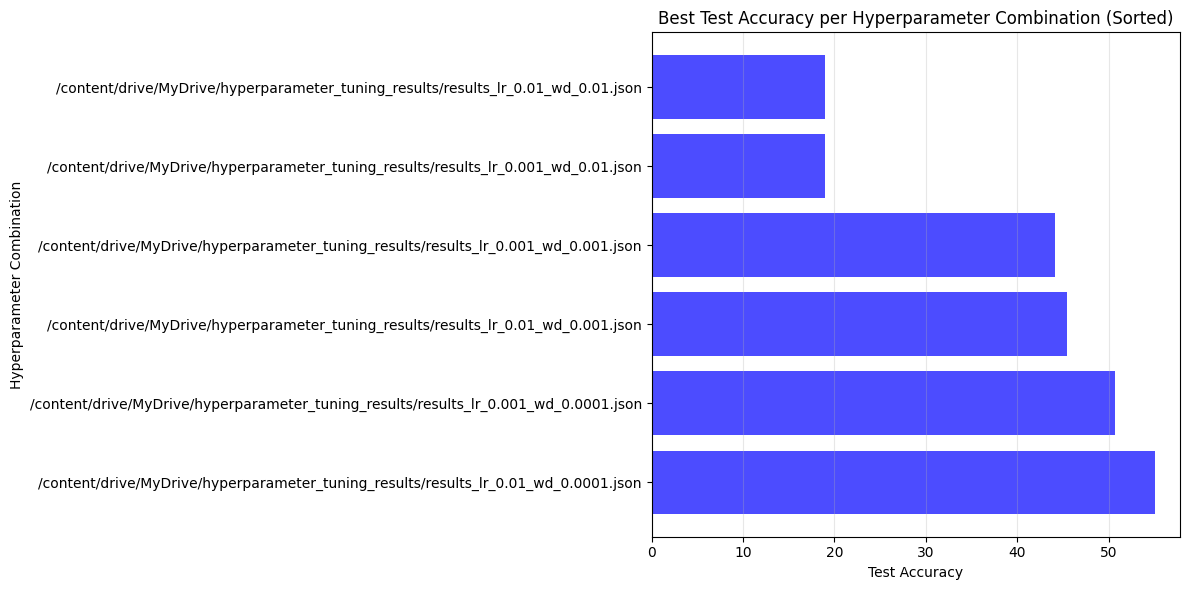

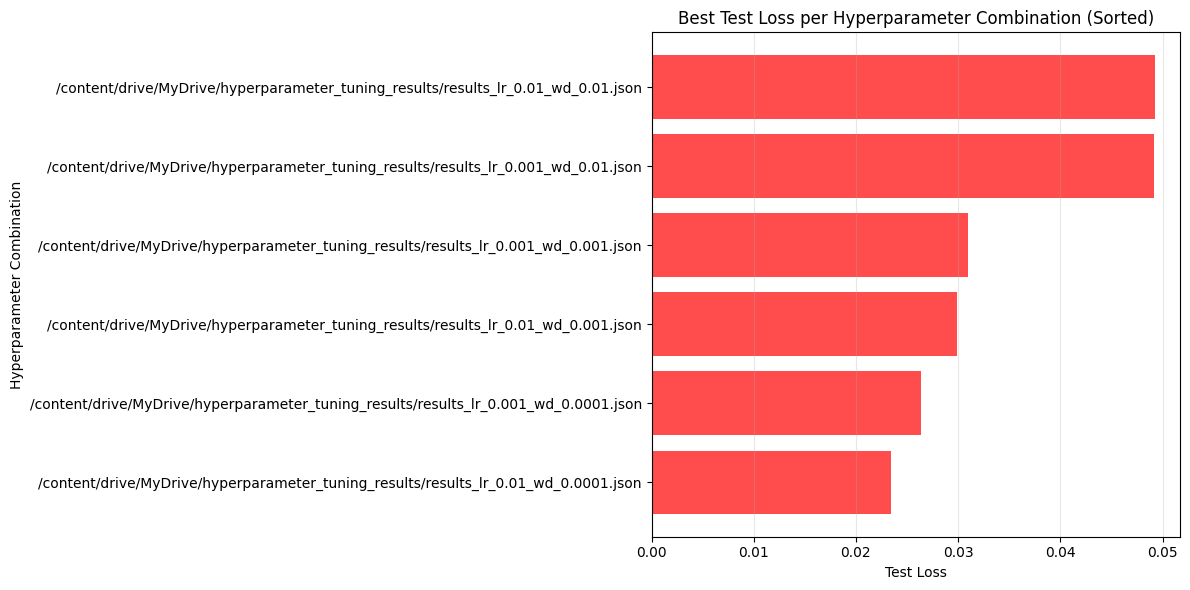

Best Hyperparameters for Test Accuracy:
Directory: /content/drive/MyDrive/hyperparameter_tuning_results
File: results_lr_0.01_wd_0.0001.json
Epoch: 10
Test Accuracy: 55.02141930567269
Corresponding Test Loss: 0.02338455183407464

Best Hyperparameters for Test Loss:
Directory: /content/drive/MyDrive/hyperparameter_tuning_results
File: results_lr_0.01_wd_0.0001.json
Epoch: 10
Test Loss: 0.02338455183407464
Corresponding Test Accuracy: 55.02141930567269


In [5]:
import os
import json
import matplotlib.pyplot as plt

# Root directory containing all subdirectories with JSON files
root_dir = "/content/drive/MyDrive/hyperparameter_tuning_results"  # Replace with your root directory path

# Initialize variables to store best results
best_accuracy = {
    "test_accuracy": 0.0,
    "file": None,
    "directory": None,
    "epoch": None,
    "test_loss": None
}
best_loss = {
    "test_loss": float('inf'),
    "file": None,
    "directory": None,
    "epoch": None,
    "test_accuracy": None
}

# Lists to store results for plotting
results = []  # Each entry is (hyperparam_combo, best_accuracy, best_loss)

# Walk through all subdirectories and files
for dirpath, _, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith(".json"):
            filepath = os.path.join(dirpath, filename)

            # Load the JSON file
            with open(filepath, 'r') as file:
                data = json.load(file)

                # Extract hyperparameter combination (assumed from directory/file name)
                hyperparam_combo = os.path.join(dirpath, filename)

                # Find the best accuracy and loss for this file
                max_accuracy = max(data, key=lambda x: x['test_accuracy'])
                min_loss = min(data, key=lambda x: x['test_loss'])

                # Update best accuracy result globally
                if max_accuracy['test_accuracy'] > best_accuracy['test_accuracy']:
                    best_accuracy.update({
                        "test_accuracy": max_accuracy['test_accuracy'],
                        "file": filename,
                        "directory": dirpath,
                        "epoch": max_accuracy['epoch'],
                        "test_loss": max_accuracy['test_loss']
                    })

                # Update best loss result globally
                if min_loss['test_loss'] < best_loss['test_loss']:
                    best_loss.update({
                        "test_loss": min_loss['test_loss'],
                        "file": filename,
                        "directory": dirpath,
                        "epoch": min_loss['epoch'],
                        "test_accuracy": min_loss['test_accuracy']
                    })

                # Store results for this combination
                results.append((hyperparam_combo, max_accuracy['test_accuracy'], min_loss['test_loss']))

# Sort results by accuracy and loss in descending order
results_sorted_by_accuracy = sorted(results, key=lambda x: x[1], reverse=True)
results_sorted_by_loss = sorted(results, key=lambda x: x[2])  # Ascending for loss

# Extract sorted values for plotting
hyperparam_combos_accuracy = [r[0] for r in results_sorted_by_accuracy]
best_accuracies = [r[1] for r in results_sorted_by_accuracy]

hyperparam_combos_loss = [r[0] for r in results_sorted_by_loss]
best_losses = [r[2] for r in results_sorted_by_loss]

# Plot the best test accuracy for each hyperparameter combination (sorted)
plt.figure(figsize=(12, 6))
plt.barh(hyperparam_combos_accuracy, best_accuracies, color='blue', alpha=0.7)
plt.xlabel("Test Accuracy")
plt.ylabel("Hyperparameter Combination")
plt.title("Best Test Accuracy per Hyperparameter Combination (Sorted)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot the best test loss for each hyperparameter combination (sorted)
plt.figure(figsize=(12, 6))
plt.barh(hyperparam_combos_loss, best_losses, color='red', alpha=0.7)
plt.xlabel("Test Loss")
plt.ylabel("Hyperparameter Combination")
plt.title("Best Test Loss per Hyperparameter Combination (Sorted)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print best hyperparameters for accuracy and loss
print("Best Hyperparameters for Test Accuracy:")
print(f"Directory: {best_accuracy['directory']}")
print(f"File: {best_accuracy['file']}")
print(f"Epoch: {best_accuracy['epoch']}")
print(f"Test Accuracy: {best_accuracy['test_accuracy']}")
print(f"Corresponding Test Loss: {best_accuracy['test_loss']}\n")

print("Best Hyperparameters for Test Loss:")
print(f"Directory: {best_loss['directory']}")
print(f"File: {best_loss['file']}")
print(f"Epoch: {best_loss['epoch']}")
print(f"Test Loss: {best_loss['test_loss']}")
print(f"Corresponding Test Accuracy: {best_loss['test_accuracy']}")
